In [54]:
# Import packages
# Ensure that visalizations are plotted inside the notebook
%matplotlib inline 

import geopandas as gpd                 # Let us work on the spatial data
import pandas as pd                     # Let us do data munging in Python 
import matplotlib.pyplot as plt         # Provides the extensive tools to visualize the data 
import seaborn as sns                   # Let us do efficent plots
from geopandas import GeoDataFrame
from pysal.lib import weights
import numpy as np                      # NumPy provides us mathematical tools to work with arrays and matricies
import contextily as cx                 # Lets us work with basemaps
import esda                             # Provide tools to work with Global and Local SA 
from sklearn.cluster import DBSCAN      # Algorithm used to identify clusters
import matplotlib.gridspec as gridspec



# Part 1
Toronto is one of the largest cities in Canada. The exploratory analysis gives us a chance to better understand this place and its local dynamics. 


In [55]:
# Load the file
neis = gpd.read_file("https://darribas.org/gds_course/_downloads/a2bdb4c2a088e602c3bd6490ab1d26fa/toronto_socio-economic.gpkg")


C:\Users\niezm\miniconda3\envs\gds\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Text(0.5, 1.0, 'Fisher jenks - income')

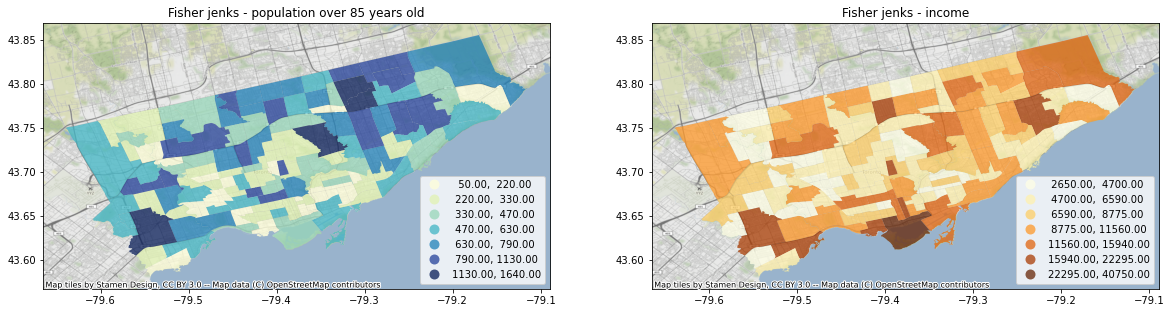

In [74]:
# Spatial distribution - plotting two choropleth maps with fisher jenks classification and Population Over 85 Years Old and Median Income 2015 variables

# Setup the figure and axis (plots two maps in the one figure)
f, ax = plt.subplots(1, 2, figsize= (20,10)) 
# Defining variable, classification, number of bins, colour, axis and position of legend for Population Over 85 variable
neis.plot(column="pop_85+_yearsold", scheme="fisher_jenks", k=7, cmap="YlGnBu", legend=True, ax=ax[0], legend_kwds={'loc' : 'lower right'}, alpha=0.75)
# Add basemap
cx.add_basemap(ax[0], crs=neis.crs)
# Setting the title of first map
ax[0].set_title('Fisher jenks - population over 85 years old')

# Defining variable, classification, number of bins, colour, axis and position of legend for Income variable
neis.plot(column="hh_median_income2015", scheme="fisher_jenks", k=7, cmap="YlOrBr", legend=True, ax=ax[1], legend_kwds={'loc' : 'lower right'}, alpha=0.75)
# Add basemap
cx.add_basemap(ax[1], crs=neis.crs)
# Setting the title of second map
ax[1].set_title('Fisher jenks - income')




This part will be analysing two variables from the ‘neis’ dataset – ‘population over 85 years old’  and ‘median income’. To explore the spatial distribution of those variables I have decided to use the fisher-jenks classification. The distribution of both variables is skewed so I have chosen a more sophisticated method of classification. According to Rey et al. (2017), a fisher-jenks algorithm is a favourable tool that classifies data in the way that the difference within the class is reduced when the difference between classes is enlarged. From the first figure, we can see that a lot of people over 85 years old are mostly located in similar places like people with higher income. The Southwest and northeast outskirts of the city are mostly inhabited by them. That might be caused by older people living in the more peaceful parts of the town and, from the second map, it can be concluded that people with higher income are looking for the same qualities from the neighbourhoods. That also agrees with the findings of Golant (2002), where the author indicated that the dwellings of retired tend to be populated with people with higher income who seek convenient places to live. 

In [57]:
# Create the spatial weight matrix
%time w=weights.Queen.from_dataframe(neis)
# Row standarize the matrix
w.transform = 'R'

Wall time: 393 ms


In [59]:
# Calculate Local Spatial autocorrelation with LISA
lisa = esda.Moran_Local(neis['pop_85+_yearsold'], w)

In [60]:
# Break observations into significant or not
neis['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
neis['quadrant'] = lisa.q

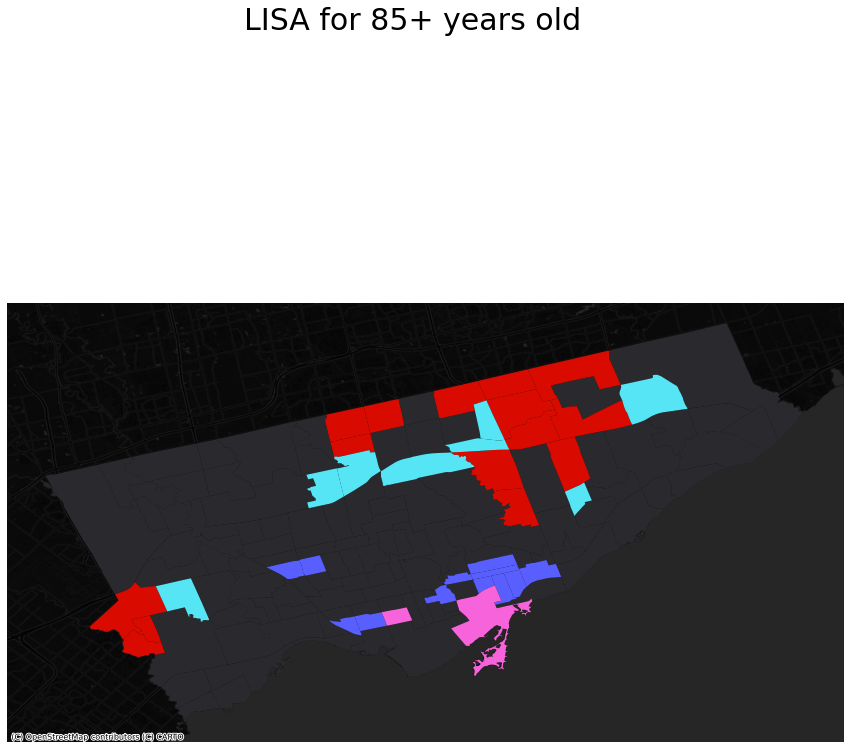

In [61]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(15, 15))
# Plot insignificant clusters
ns = neis.loc[neis['significant']==False, 'geometry']
ns.plot(ax=ax, color='#2a2a2e')
# Plot HH clusters
hh = neis.loc[(neis['quadrant']==1) & (neis['significant']==True), 'geometry']
hh.plot(ax=ax, color='#d90b00')
# Plot LL clusters
ll = neis.loc[(neis['quadrant']==3) & (neis['significant']==True), 'geometry']
ll.plot(ax=ax, color='#595fff')
# Plot LH clusters
lh = neis.loc[(neis['quadrant']==2) & (neis['significant']==True), 'geometry']
lh.plot(ax=ax, color='#56e5f5')
# Plot HL clusters
hl = neis.loc[(neis['quadrant']==4) & (neis['significant']==True), 'geometry']
hl.plot(ax=ax, color='#f763da')
# Add title
f.suptitle('LISA for 85+ years old', size=30)
# Add basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Remove axis
ax.set_axis_off()
# Draws map
plt.show()

I have chosen to explore the degree of Local Spatial autocorrelation to analyse the distribution of people over 85 years old that live in Toronto. Exploratory Spatial Data Analysis (ESDA) tools are useful to explore local trends that are different than a common one. To visualise this, I have used Local Indicators of Spatial Association (LISA). The second figure shows instability in the ‘Population over 85 years old’ distribution plotted with LISA methodology. Bright red located in the northeast and west part of Toronto, indicate the high unusual concentration of older people. In pink on the south of Toronto, we can see spatial outliners where elderly are living but in the neighbouring areas, there is much lover concentration of them. From Google Maps we can indicate that the older population of Toronto tends to live in neighbourhoods that include a lot of green spaces and golf clubs. On the other hand, the areas neighbouring the pink area of concertation might be connected to the youthification of the city centres. According to Revington (2018), the gentrification of the heart of the city is connected to the young adult moving patterns. It might be also connected to the fact that the university is located in the area so there might be a cluster of the younger people that is outlining the cluster of the retired. 

# Part 2

In [63]:
# Load a file
photos = pd.read_csv("https://darribas.org/gds_course/_downloads/fc771c3b1b9e0ee00e875bb2d293adcd/toronto_flickr_subset.csv")

In [64]:
# Attaching the neighbourhood names to the photos dataframe
photos_gdf = gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            photos["longitude"], photos["latitude"]
        )
    }, crs="EPSG:4326"
).join(photos)
crosswalk = gpd.sjoin(photos_gdf, neis, how="inner")
photos["neighbourhood_name"] = crosswalk["neighbourhood_name"]

In [65]:
# Take a random subset of 2000 rows from `photos`
photos_sub = photos.sample(2000, random_state=12345)

In [66]:
# Set up algorithm
algo = DBSCAN(eps=200, min_samples=50)

In [67]:
# Express points in metres
# Convert lon/lat into Point objects + set CRS
pts = gpd.points_from_xy(
    photos["longitude"],
    photos["latitude"],
    crs="EPSG:4326"
)
# Convert lon/lat points to Canadian CRS in metres
pts = gpd.GeoDataFrame({"geometry": pts}).to_crs(epsg=3978)
# Extract coordinates from point objects into columns
photos["X_metres"] = pts.geometry.x
photos["Y_metres"] = pts.geometry.y

In [69]:
# 'Fitting' the data to parametes
algo.fit(photos[["X_metres", "Y_metres"]])

DBSCAN(eps=200, min_samples=50)

In [70]:
# Recovering the labels
algo.labels_

array([ 4,  0, -1, ..., -1, -1,  3], dtype=int64)

In [71]:
# Turning labels into a Series object 
lbls = pd.Series(algo.labels_, index=photos.index)

C:\Users\niezm\miniconda3\envs\gds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'KDE of photos in Toronto')

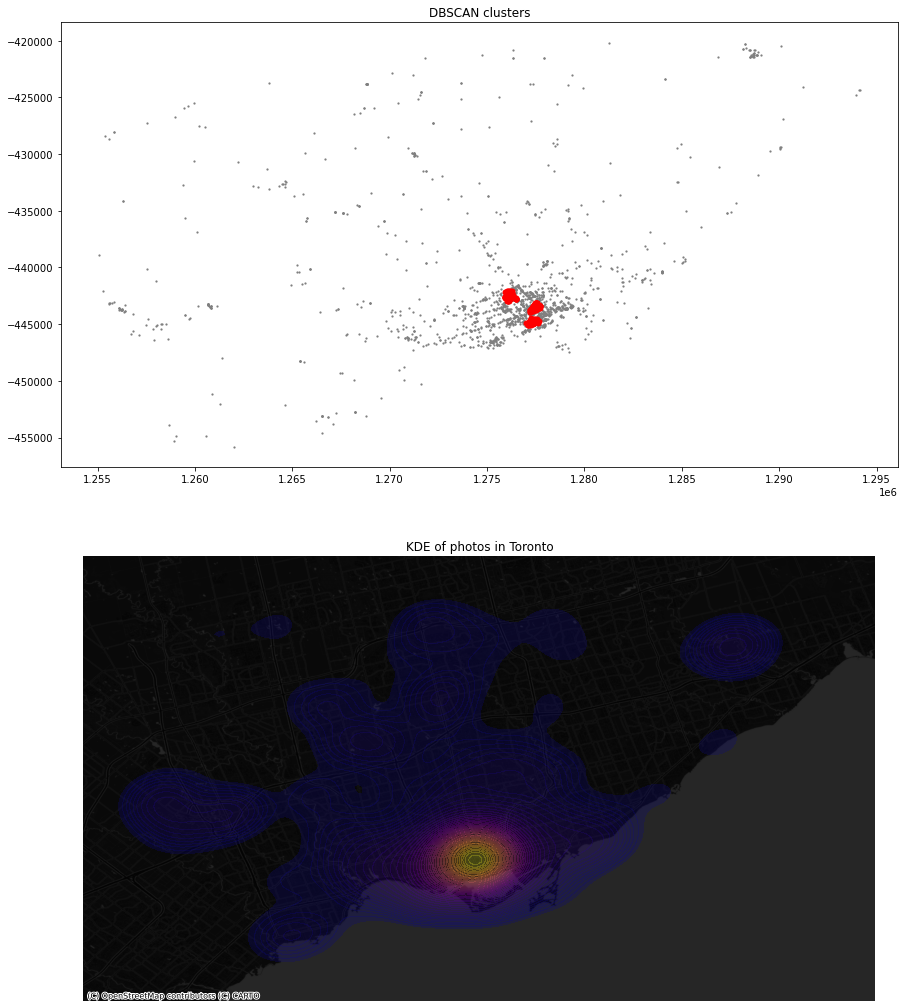

In [72]:
# Setup figure and axis
f, ax = plt.subplots(2, 1, figsize=(15,18))
# Assign labels to photos table dynamically and subset points that are not part of any cluster (noise)
noise = photos.assign(
    lbls=lbls
).query("lbls == -1")
# Plot noise in grey
ax[0].scatter(
    noise["X_metres"], 
    noise["Y_metres"], 
    c='grey', 
    s=5, 
    linewidth=0
)
# Plot all points that are not noise in red
ax[0].scatter(
    photos.loc[photos.index.difference(noise.index), "X_metres"], 
    photos.loc[photos.index.difference(noise.index), "Y_metres"],
    c="red", 
    linewidth=0
)
ax[0].set_title("DBSCAN clusters")


# Add KDE layer that displays probability surface
sns.kdeplot(
    photos_sub["longitude"], 
    photos_sub["latitude"], 
    n_levels=50, 
    shade=True,
    alpha=0.25,
    cmap="plasma",
    ax=ax[1]
)
# Remove axis
ax[1].set_axis_off()
# Add basemap
cx.add_basemap(
    ax[1], 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax[1].set_title("KDE of photos in Toronto")


To visualise the dataset with the localizations of photographs I have used the kernel density estimate (KDE). Because it avoids the geography of the and boundaries and continuously calculates the points, it is a better approach when the modifiable areal unit problem is probable (Anderson, 2009). To run the algorithm, I have selected a random 2000 sample of points to make the work easier and faster.  From the map, we can see that the likelihood of taking the photo is the biggest in the north part of Toronto. From Google Maps we can discover that this is an area called Old Toronto, where is most of the downtown and tourist attractions are located.

To run the DBSCAN algorithm I have used the exploratory analysis to choose the right parameters. I have tweaked them to be able to identify clusters that are the most important. In the end, I have used a minimum of 50 photos within 200 meters from them. DBSCAN algorithm is giving us similar results to the KDE, where the biggest probability of photos is located in Old Toronto, thus one of the most touristic parts of the town. The identified red clusters are located in the same place as the highest probability of KDE. It is proving that people are taking photos in the areas of interest, here the tourist attractions. According to Pavlis et al. (2018), DBSCAN clusters can be helpful when planning the location of the retail centres. They concluded that clusters indicated the desired place of the shops that was suggested by councils. Having the retail centre in the area of high interest where a lot of tourists spend their time, for sure would be a profitable for the local economy as people would tend to spend more money there. 

*word count: 746*


Bibliography:


Anderson, T. K. (2009) 'Kernel density estimation and K-means clustering to profile road accident hotspots', Accident Analysis & Prevention, 41(3), pp. 359-364.

Golant, S. M. (2002) 'Deciding Where to Live: The Emerging Residential Settlement Patterns of Retired Americans', Journal of the American Society on Aging, 26(2), pp. 66-73.

Pavlis, M., Dolega, L. and Singleton, A. (2018) 'A Modified DBSCAN Clustering Methodto Estimate Retail Center Extent', Geographical Analysis, 50(2), pp. 141-161.

Revington, N. (2018) 'Pathways and Processes: Reviewing the Role of Young Adults in Urban Structure', The Professional Geographer, 70(1), pp. 1-10.

Rey, S. J., Stephens, P. and Laura, J. (2017) 'An evaluation of sampling and full enumeration strategies for Fisher Jenks classification in big data settings', Transactions in GIS, 21(4), pp. 796-810.


